# Project 2 source code

In [56]:
# exercise 8.1.1
from sklearn.datasets import load_diabetes
import pandas as pd
import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection
from dtuimldmtools import rlr_validate


# Load dataset from sklearn
X,y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

# Convert to pandas dataframe
X = pd.DataFrame(X)
y = pd.DataFrame(y)

# # Standardize data
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

# Rename columns
X.rename(columns={'s1':'tc', 's2': 'ldl', 's3': 'hdl', 's4': 'tch', 's5': 'ltg', 's6': 'glu'}, inplace=True)

# Add Offset
X['Offset'] = 1

# Move offset to first position
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

# Number of samples and features: N = samples, M = features
N, M = X.shape

# attribute names
attributeNames = X.columns

# Convert pandas dataframe to numpy array
X = X.to_numpy()
y = y.to_numpy().flatten()

## Simple test

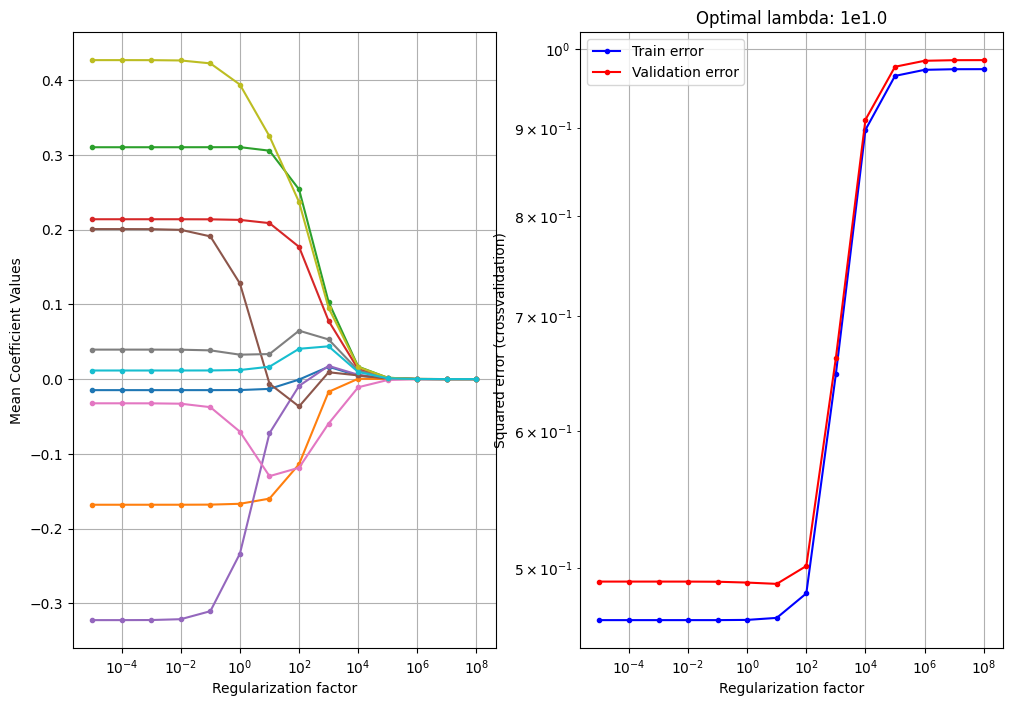

Linear regression without feature selection:
- Training error: 0.4780130864634341
- Test error:     0.5097677850182148
- R^2 train:     0.520531117147155
- R^2 test:     0.48260637615439117

Regularized linear regression:
- Training error: 0.479888221153268
- Test error:     0.5099770577452333
- R^2 train:     0.5186502717050667
- R^2 test:     0.4823939728252945

Weights in last fold:
         Offset           -0.03
            age           -0.01
            sex           -0.16
            bmi            0.31
             bp            0.21
             tc           -0.08
            ldl            -0.0
            hdl           -0.13
            tch            0.03
            ltg            0.33
            glu            0.02
Ran Exercise 8.1.1


In [54]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

print("Ran Exercise 8.1.1")


### ANN Regression

In [69]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


# clone detached data
X = torch.tensor(X, dtype=torch.float32).clone().detach()
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).clone().detach()

# Hidden units
hidden_units = 3

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, hidden_units)  # 11 input features to match your data
        self.fc2 = nn.Linear(hidden_units, 1)  # 50 hidden units, 1 output unit (for regression)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()


# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(X)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Define the model architecture
    model = Net()
    
    # Define the loss function and the optimizer
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent
    
    # Extract train and test data
    X_train, y_train = X[train_ids], y[train_ids]
    X_test, y_test = X[test_ids], y[test_ids]
    
    # Train the model
    max_iter = 10000
    epochs = max_iter
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        # print('Epoch: ', epoch, ' Loss: ', loss.item())
    
    # Test the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        print(f'Loss for fold {fold}: {loss.item()}')

C:\Users\viet-intel\AppData\Local\Temp\ipykernel_24224\2234698856.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32).clone().detach()
C:\Users\viet-intel\AppData\Local\Temp\ipykernel_24224\2234698856.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).clone().detach()


FOLD 0
--------------------------------
Loss for fold 0: 0.5093269348144531
FOLD 1
--------------------------------
Loss for fold 1: 0.5709251165390015
FOLD 2
--------------------------------
Loss for fold 2: 0.4839930534362793
FOLD 3
--------------------------------
Loss for fold 3: 0.54683518409729
FOLD 4
--------------------------------
Loss for fold 4: 0.5311214923858643
FOLD 5
--------------------------------
Loss for fold 5: 0.4505413770675659
FOLD 6
--------------------------------
Loss for fold 6: 0.5486376881599426
FOLD 7
--------------------------------
Loss for fold 7: 0.38603973388671875
FOLD 8
--------------------------------
Loss for fold 8: 0.616513192653656
FOLD 9
--------------------------------
Loss for fold 9: 0.34043633937835693
